# Prediction of emergency room arrivals

## Initialization

### Initial import

In [1]:
%pylab inline

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost

from math import sqrt

from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
errosDict= pd.DataFrame(columns =['P0', 'P1', 'P2', 'P3', 'P5'])

def compare_prediction (real, pred) : 
    result = abs(real - pred)
    return [round(100 * sum(list(map(lambda x : x<1, result)))/len(result),1), 
            round(100 * sum(list(map(lambda x : x>=1 and x<2, result)))/len(result),1), 
            round(100 * sum(list(map(lambda x : x>=2 and x<3, result)))/len(result),1), 
            round(100 * sum(list(map(lambda x : x>=3 and x<5, result)))/len(result),1), 
            round(100 * sum(list(map(lambda x : x>=5, result)))/len(result),1)]

### Loading data

In [3]:
#%load_ext autotime
filename = "a1-hourly_dataset"
#filename = "a2-daily_dataset"
df = pd.read_csv("DATA/FINAL/"+filename + ".csv")
df["date_hour"] = pd.to_datetime(df["date_hour"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
df["day"] = pd.to_datetime(df["day"], format="%Y-%m-%d", errors='coerce')
df.index = pd.DatetimeIndex(df.date_hour,name="date_hour_index")

In [4]:
df2 = pd.read_csv("DATA/FINAL/Mercy.csv")

In [5]:
df2.index = pd.DatetimeIndex(pd.to_datetime(df2["date"], format="%Y-%m-%d %H:%M:%S", errors='coerce'),
                             name="date_hour_index")

In [6]:
df2.drop('date', axis=1, inplace=True)

In [7]:
df2

,patients,encours
date_hour_index,,
2010-01-01 00:00:00,3,3
2010-01-01 01:00:00,9,9
2010-01-01 02:00:00,16,15
2010-01-01 03:00:00,24,24
2010-01-01 04:00:00,28,27
...,...,...
2020-04-30 19:00:00,41,41
2020-04-30 20:00:00,45,40
2020-04-30 21:00:00,49,41


In [7]:
df.drop('patients', axis=1, inplace=True)
df = df2.merge(df, how='left', left_index=True, right_index=True)

In [9]:
df

,patients,encours,site,day,hour,week,dayofweek,month,dayofmonth,year,...,numer_sta_strasbourg,accademic_holiday,moon_phase,public_holiday_eve,rr3_strasbourg,chpox_inc,public_holiday_next_day,rafper_nancy,pmer_strasbourg,rr1_nancy
date_hour_index,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,3,3,Mercy,2010-01-01,0.0,53.0,4.0,1.0,1.0,2010.0,...,7190.0,1.0,4.0,0.0,0.0,inf,0.0,3.6,99200.0,0.0
2010-01-01 01:00:00,9,9,Mercy,2010-01-01,1.0,53.0,4.0,1.0,1.0,2010.0,...,7190.0,1.0,4.0,0.0,0.0,inf,0.0,3.6,99200.0,0.0
2010-01-01 02:00:00,16,15,Mercy,2010-01-01,2.0,53.0,4.0,1.0,1.0,2010.0,...,7190.0,1.0,4.0,0.0,0.0,inf,0.0,3.6,99200.0,0.0
2010-01-01 03:00:00,24,24,Mercy,2010-01-01,3.0,53.0,4.0,1.0,1.0,2010.0,...,7190.0,1.0,4.0,0.0,0.0,inf,0.0,4.6,99140.0,0.2
2010-01-01 04:00:00,28,27,Mercy,2010-01-01,4.0,53.0,4.0,1.0,1.0,2010.0,...,7190.0,1.0,4.0,0.0,0.0,inf,0.0,4.6,99140.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30 19:00:00,41,41,Mercy,2020-04-30,19.0,18.0,3.0,4.0,30.0,2020.0,...,7190.0,1.0,2.0,1.0,3.6,1528.0,0.0,12.2,100600.0,0.0
2020-04-30 20:00:00,45,40,Mercy,2020-04-30,20.0,18.0,3.0,4.0,30.0,2020.0,...,7190.0,1.0,2.0,1.0,3.6,1528.0,0.0,12.2,100600.0,0.0
2020-04-30 21:00:00,49,41,Mercy,2020-04-30,21.0,18.0,3.0,4.0,30.0,2020.0,...,7190.0,1.0,2.0,1.0,0.0,1528.0,0.0,15.7,100670.0,0.0


### Cleaning data

In [8]:
df = df.loc[df.index.year<2020]
df = df.loc[~((df.index.day == 29) & (df.index.month == 2))]

In [9]:
df.month = df.index.month
df.dayofyear = df.index.dayofyear
df.dayofweek = df.index.dayofweek
df.hour = df.index.hour

In [10]:
df = df.replace(np.inf, np.nan)
df = df.bfill()

## Target visualization

In [11]:
series = pd.Series(data=df.patients.values, index=df.index)

In [12]:
series

date_hour_index
2010-01-01 00:00:00     3
2010-01-01 01:00:00     9
2010-01-01 02:00:00    16
2010-01-01 03:00:00    24
2010-01-01 04:00:00    28
                       ..
2019-12-31 19:00:00    10
2019-12-31 20:00:00    16
2019-12-31 21:00:00    15
2019-12-31 22:00:00     9
2019-12-31 23:00:00    12
Length: 87600, dtype: int64

In [13]:
series.describe()

count    87600.000000
mean        23.633619
std         12.286131
min          0.000000
25%         15.000000
50%         22.000000
75%         30.000000
max        143.000000
dtype: float64

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<AxesSubplot:>

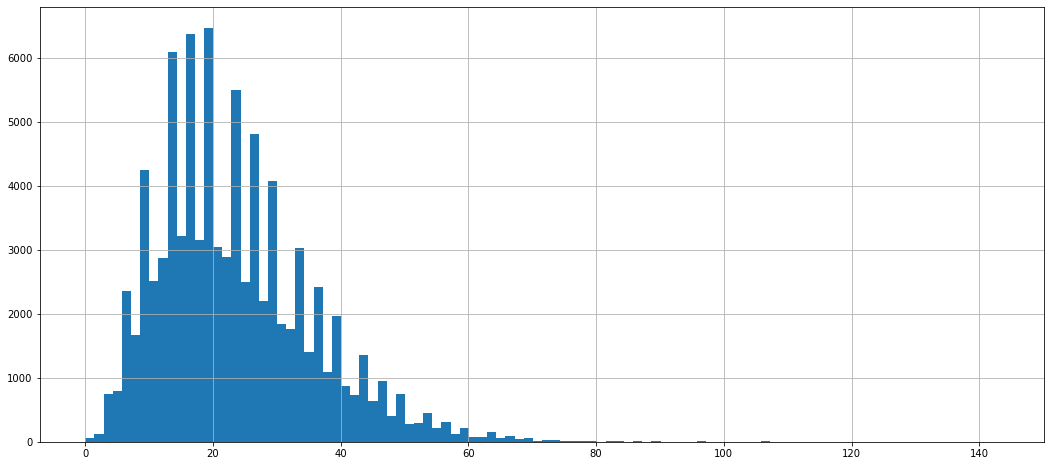

In [14]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)
series.hist(bins=100)

<AxesSubplot:xlabel='date_hour_index'>

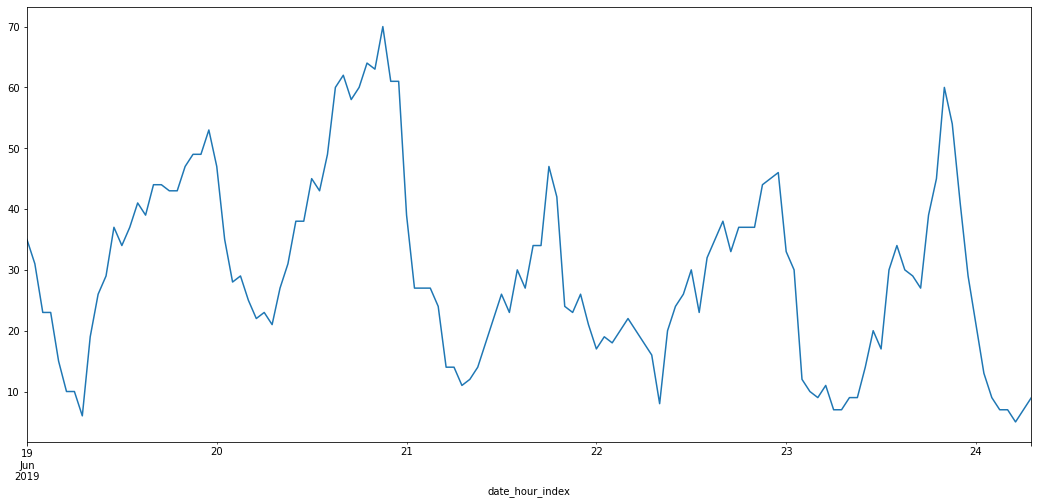

In [15]:
series['2019-06-19 00:00:00':'2019-06-24 07:00:00'].plot()

<AxesSubplot:xlabel='date_hour_index'>

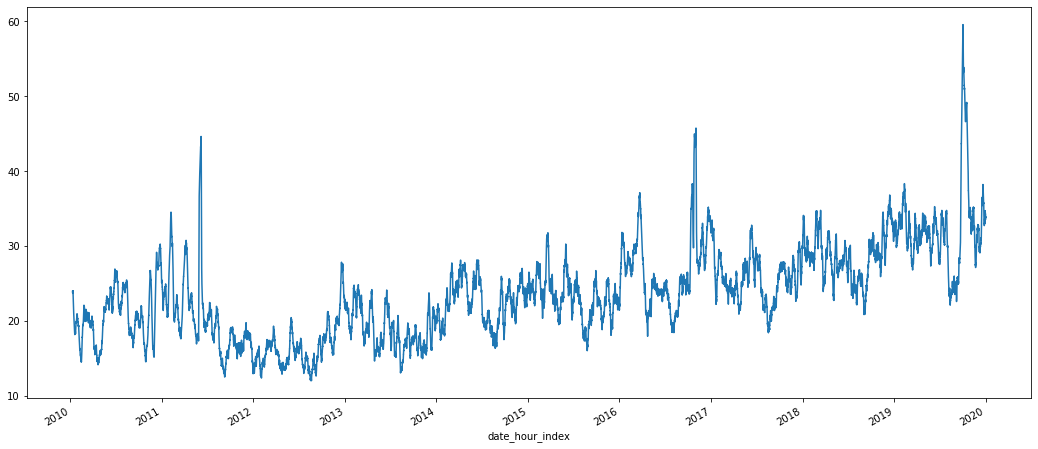

In [17]:
shifted = series.shift(1)
window = shifted.rolling(window=240)
means = window.mean()
means.plot()

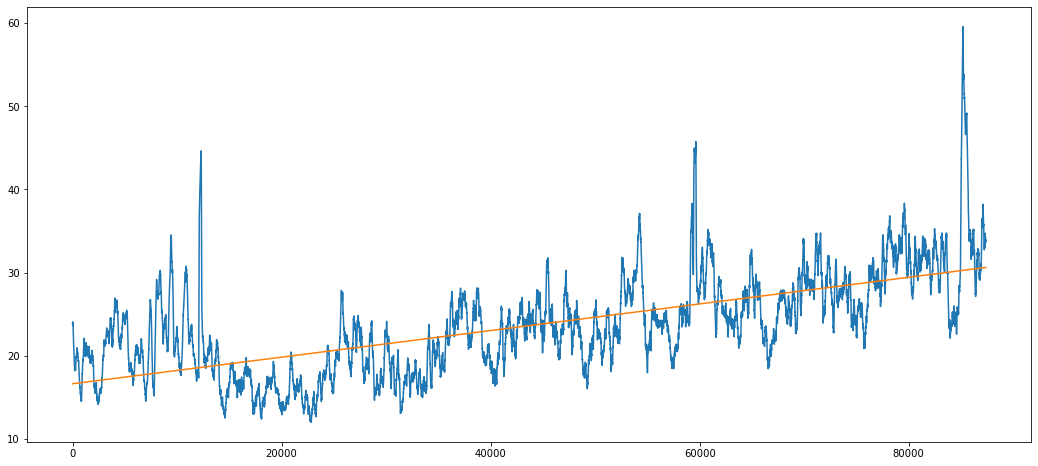

In [18]:
from sklearn.linear_model import LinearRegression

y = means.values[240:]
X = np.array(range(len(y))).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
pyplot.plot(X,means[240:])
pyplot.plot(X,trend)

In [19]:
print(f"{model.coef_[0]:.7F}, {(model.coef_*50000)[0]:.4f}")

0.0001601, 8.0044


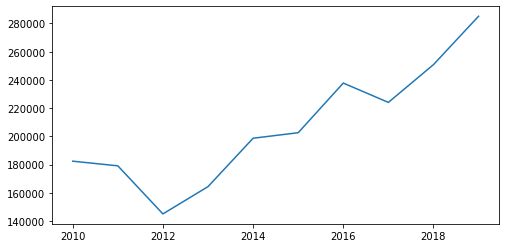

In [20]:
pylab.rcParams['figure.figsize'] = (8, 4)
plt.plot(range(2010,2020), [series[str(k)].sum() for k in range(2010,2020)])
pylab.rcParams['figure.figsize'] = (18, 8)

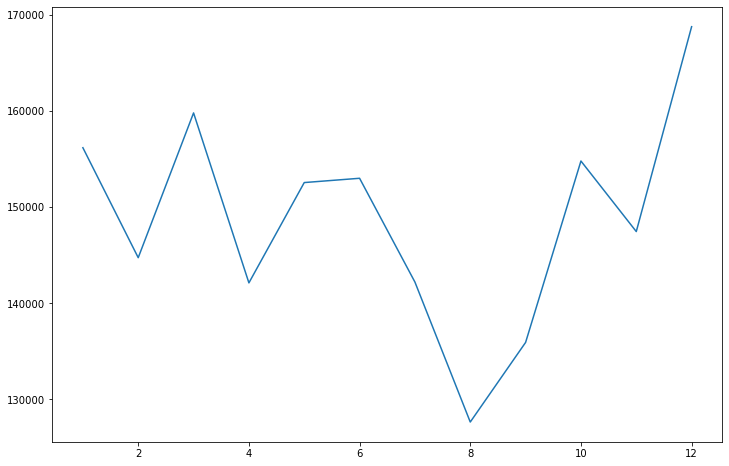

In [21]:
pylab.rcParams['figure.figsize'] = (12, 8)

g=df.groupby(['month','year'])
years = sorted(set(df.year.values))[:-1]
months = sorted(set(df.month.values))
plt.plot(range(1,13), [sum([g.get_group((int(l),int(k)))['patients'].sum() for k in years]) for l in months])

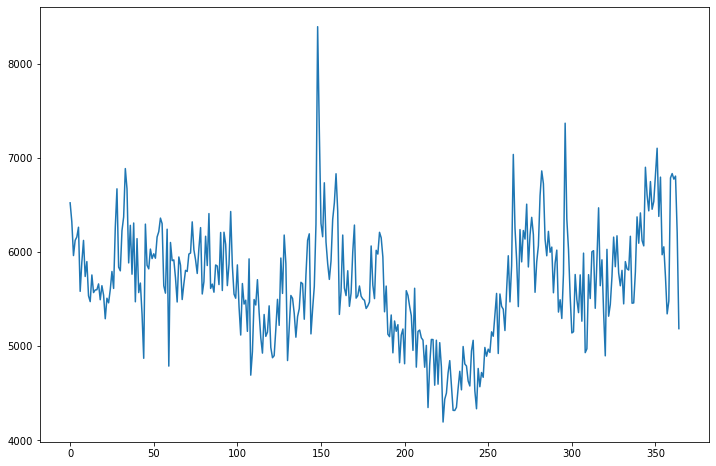

In [22]:
dd = df.loc[~((df.index.day == 29) & (df.index.month == 2))]
perday = [dd.loc[dd.dayofyear == k].patients.sum() for k in range(1,366)]
plt.plot(perday)

<AxesSubplot:>

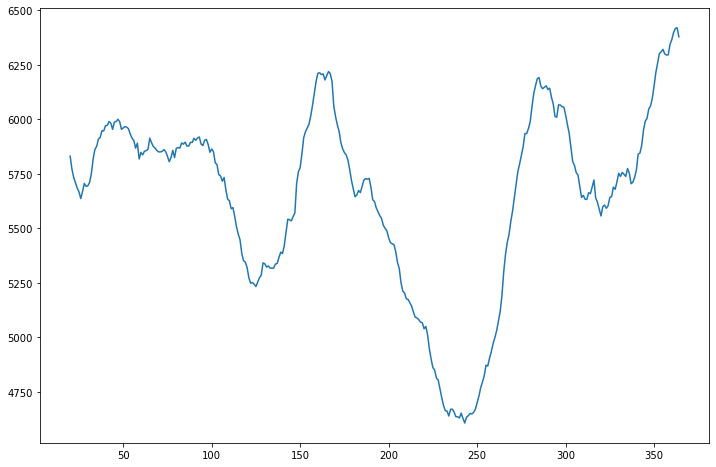

In [23]:
perday = pd.Series(perday)
window = perday.rolling(window=7*3)
means = window.mean()
means.plot()

(0.0, 125.0)

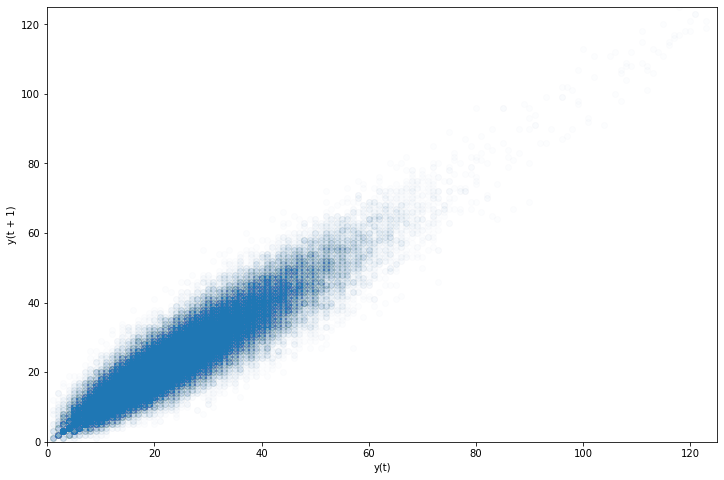

In [24]:
ax = pd.plotting.lag_plot(series, alpha=0.01)
ax.set_xlim([0, 125])
ax.set_ylim([0, 125])

(0.0, 168.0)

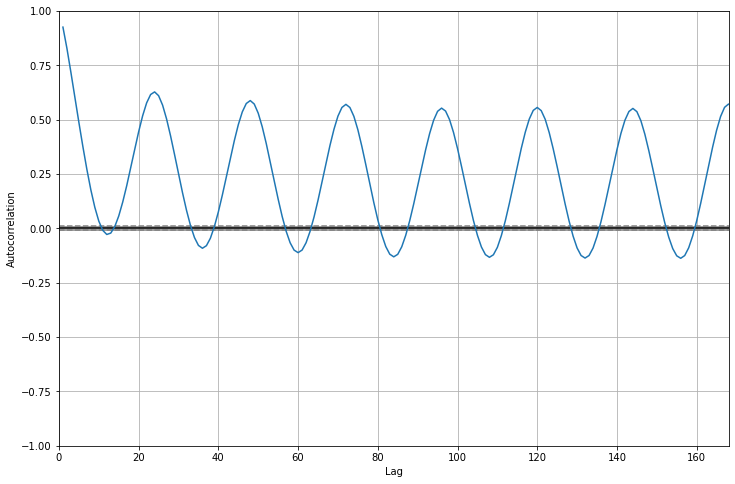

In [25]:
ax = pd.plotting.autocorrelation_plot(series)
ax.set_xlim([0, 24*7])

In [26]:
df0 = df.copy()
df0['hour'] = df0.index.hour
df0['dow'] = df0.index.dayofweek
df0['month'] = df0.index.month

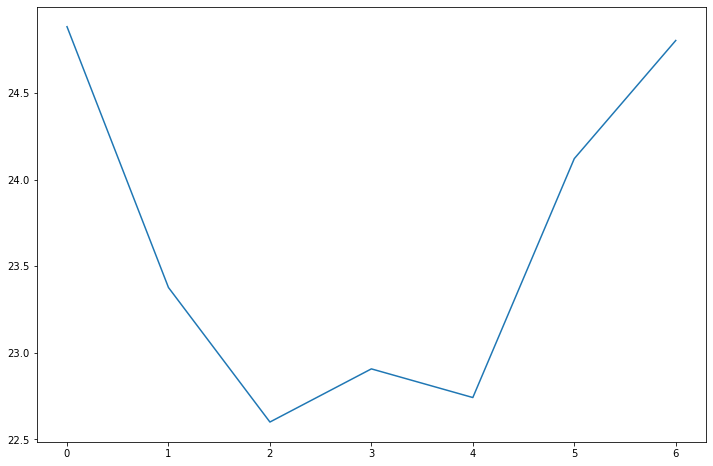

In [27]:
plt.plot(range(7), [df0.loc[df0.dow==k].patients.mean() for k in range(7)])

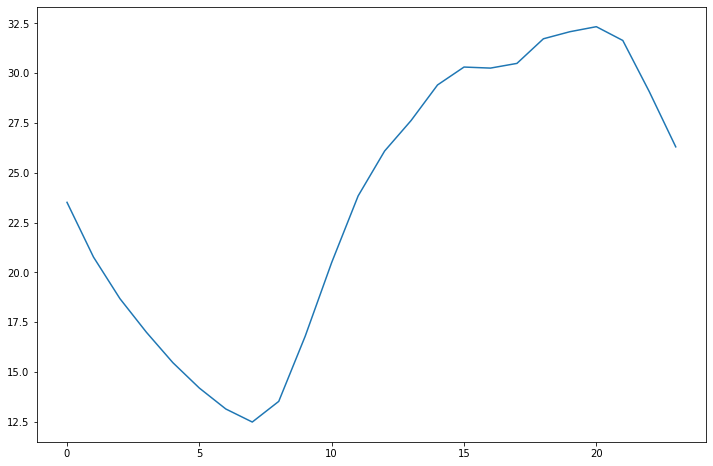

In [28]:
plt.plot(range(24), [df0.loc[df0.hour==k].patients.mean() for k in range(24)])

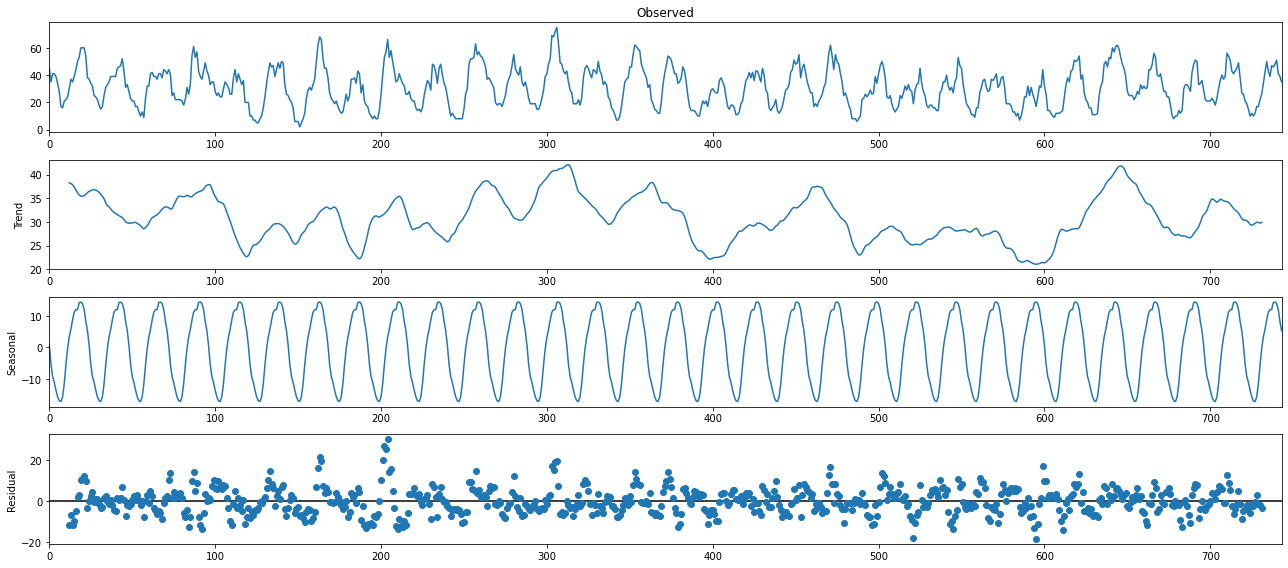

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
pylab.rcParams['figure.figsize'] = (18, 8)

result = seasonal_decompose(list(series['2019-05']),
                            period=24)
result.plot()
pyplot.show()

the number of cases may be just a cyclical
change, a baseline model should be provided to compare the superiority of
machine learnig model;

S'il s'agit uniquement de changements cycliques, le signal correspondrait à sa partie saisonnière dans une décomposition du même nom. On peut approximer le signal par sa composante saisonnière, pour voir à quel point un tel prédicteur appoxime bien le signal. On compare déjà le réel avec le prédit d'une telle manière : 

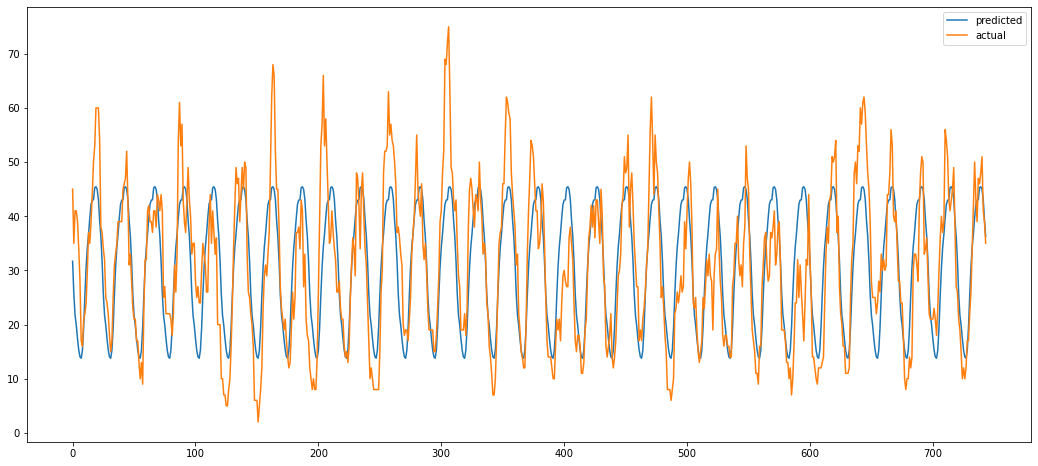

In [38]:
plot(result.seasonal + [result.observed.mean()]*len(result.seasonal), label="predicted")
plot(result.observed, label = "actual")
legend()

On affiche les résidus (erreurs de prédiction) : 

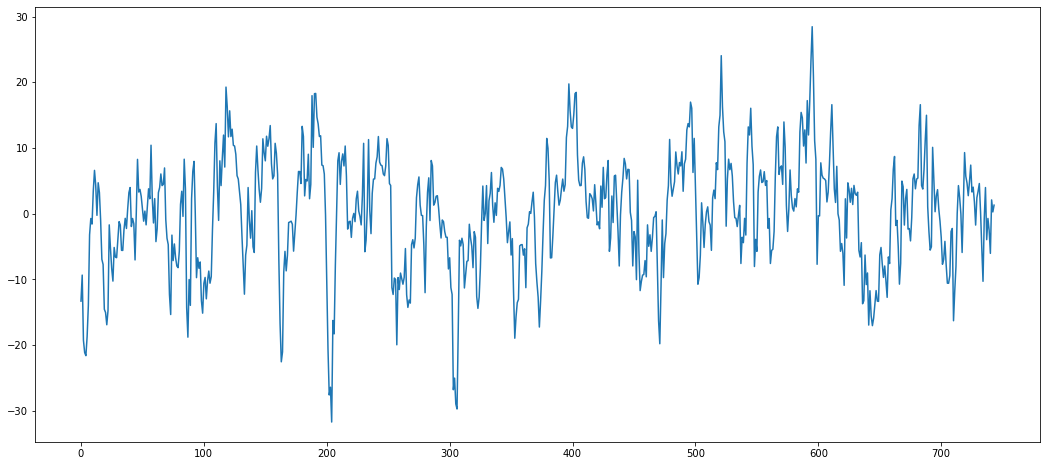

In [39]:
plot(result.seasonal + [result.observed.mean()]*len(result.seasonal)-result.observed, label="predicted")

Il n'y a plus de saisonnalité dans la courbe des résidus, ce qui est attendu, et l'on a une moyenne nulle. Les erreurs peuvent cependant être assez grandes (forte variance). Calculons la MAE et la RMSE de cette baseline :

In [40]:
mean_absolute_error(result.seasonal + [result.observed.mean()]*len(result.seasonal),result.observed)

6.734298133073348

In [41]:
sqrt(mean_squared_error(result.seasonal + [result.observed.mean()]*len(result.seasonal), result.observed))

8.581469193351056

Ces valeurs seront à comparer avec les autres scores, pour justifier de l'intérêt d'une approche de type machine learning.

 Some time series analysis (ex. ARIMA) should be conducted.

On va tester les approches auto-régressive AR (méthode basique), ainsi que l'ARIMA.

In [43]:
dataframe = pd.concat([series.shift(1), series], axis=1)

In [44]:
dataframe.columns = [ ' t ' , ' t+1 ' ]

In [45]:
dataframe.corr()

,t,t+1
t,1.000000,0.925493
t+1,0.925493,1.000000


On constate une forte corrélation entre la série des patients, et sa version décalée d'une unité de temps : le signal est fortement auto-corrélé, et utiliser le nombre de patients aux temps t, t-1,... semble une bonne idée pour prédire celui au temps t+1. Cela est clairement apparent dans le graphe d'auto-corrélation :

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


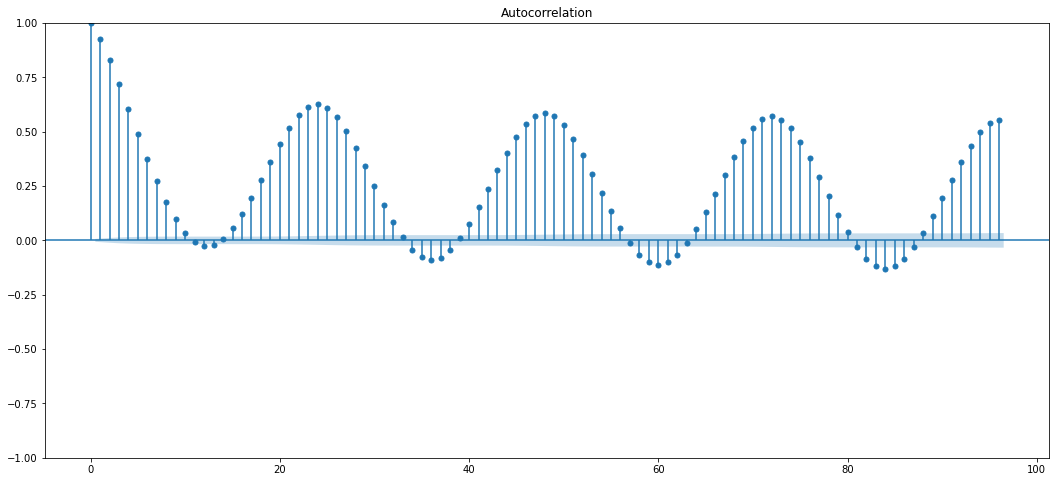

In [46]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=24*4)
show()

In [ ]:
(on revoit apparaître la saisonnalité journalière).

Dans tous les cas, on peut conclure que le modèle AR est pertinent pour cette série. Le modèle AR dépend du nombre de retards à considérer dans la régression. On peut regarder s'il y a des valeurs à ignorer pour ce paramètre, par une approche "conditional maximum likelihood estimation".

In [52]:
from statsmodels.tsa.ar_model import ar_select_order
res = ar_select_order(series.values, maxlag=100)

In [53]:
res.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98]

Aucune valeur n'est à banir. Au vu des tendances saisonnières, on prend en compte un retard allant jusqu'à 4 jours (aller plus loin complexifierait inutilement le modèle).

In [51]:
from statsmodels.tsa.ar_model import AutoReg

predictions = []
for k in range(100):
    train, test = series.values[:len(series)-100+k], series.values[len(series)-100+k]
    model = AutoReg(train, lags=24*4)
    model_fit = model.fit()
    predictions.append(model_fit.predict(start=len(train), 
                                    end=len(train), 
                                    dynamic=False))

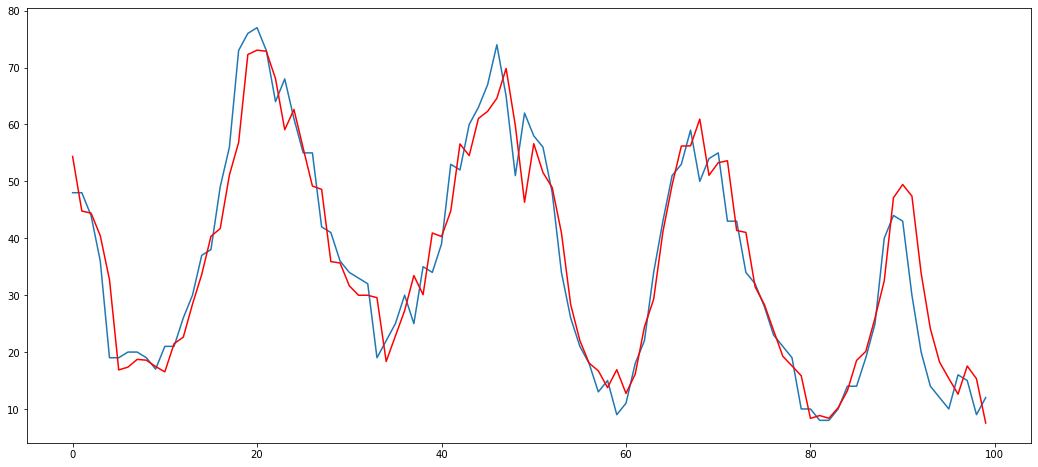

In [55]:
plot(range(100), series[-100:])
plot(range(100), predictions, color= 'red')

On calcule la RMSE et la MAE pour le modèle AR, sur les 100 dernières observations :

In [58]:
mean_absolute_error(series[-100:], predictions), sqrt(mean_squared_error(series[-100:], predictions))

(4.2507741772370355, 5.6594825887165685)

Ces valeurs sont au-delà de celles que nous obtiendrons par des approches de machine learning.

Le modèle ARIMA, quant à lui, dépend de trois paramètres : 
- p (lag order) correspond au nombre d’observations passées intégrées dans le modèle.
- d (degree) correspond au nombre de soustractions opérées.
- q (order of moving average) correspond à la taille de la fenêtre la moyenne glissante (pour la série des résidus).
On peut passer par une grille pour trouver les paramètres optimaux, mais c'est très coûteux. On peut aussi suivre l'approche suivante, bien documentée dans la litérature :
- s’il y a une tendance générale à l’augmentation (ou a la diminution), i.e. une pente non nulle dans la régression linéaire, alors une étape de soustraction (d=1) peut être la bienvenue pour supprimer cette tendance. S’il y a une tendance à l’augmentation des fluctuations, on peut passer à d=2.
- Pour trouver la valeur de p, on trace le graphe d’autocorrélation, et on prend le plus grand retard encore significatif à 95%.
- Pour q, on fait de même, mais avec le graphe d’autocorrélation partielle.

On a vu précédemment qu'il y avait une tendance à la hausse, avec un bon coefficient de corrélation linéaire. On prend donc d=1.

Sur le graphe d'autocorrélation ci-dessus, on voit que le plus grand retard encore significatif à 95% est p=2 (à p=3, on est à ~85%).

Affichons maintenant le graphe d'autocorrélation partielle : 

/usr/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


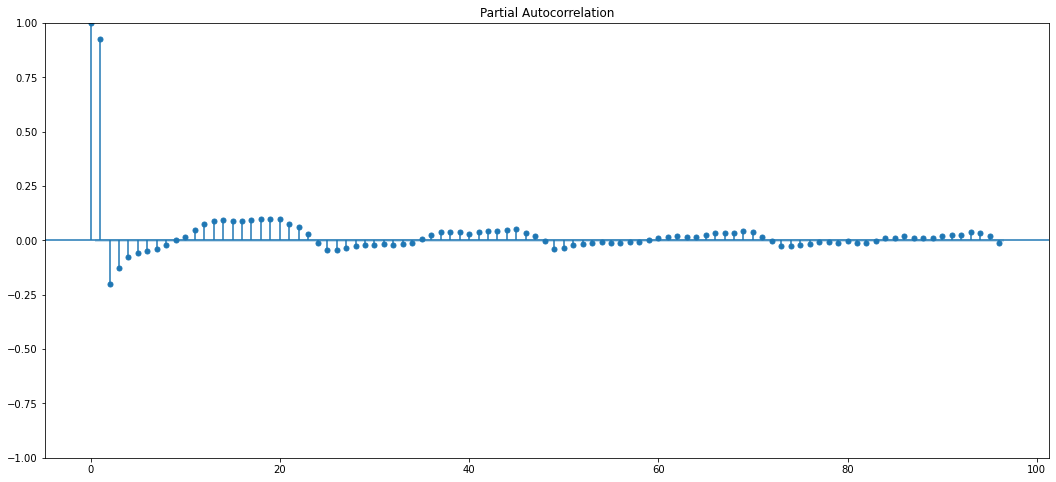

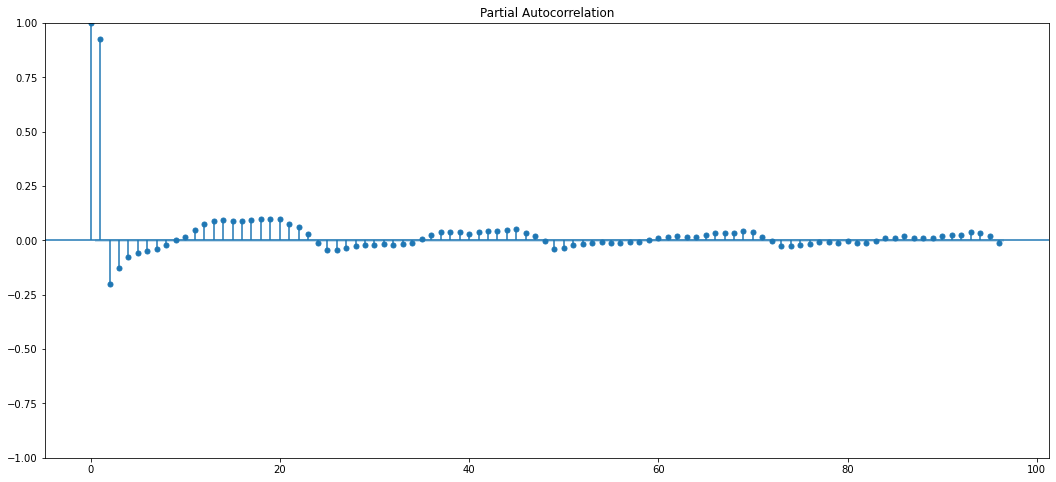

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=24*4)

De même, on a une chute de l'autocorrélation partielle au-delà de q=2. On peut maintenant mettre en place le modèle :

In [63]:
from statsmodels.tsa.arima.model import ARIMA
X = series.values
size = 48
train, test = X[:-size], X[-size:]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Test RMSE: 5.393
Test MAE: 3.966


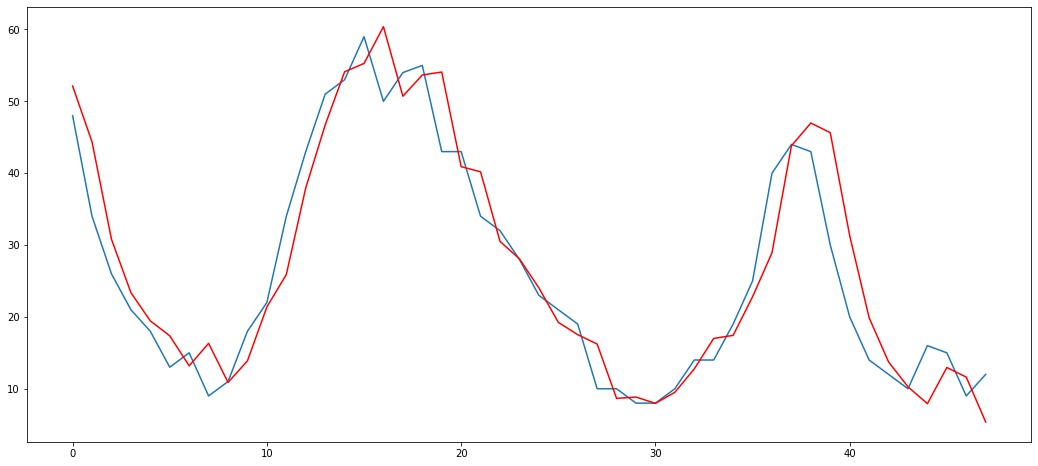

In [67]:
from matplotlib import pyplot

rmse = sqrt(mean_squared_error(list(test), list(predictions)))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(list(test), list(predictions))
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
pyplot.plot(test[:100])
pyplot.plot(predictions[:100], color='red')
pyplot.show()

Les scores sont toujours moins bons que l'approche ML.

In [31]:
import numpy as np
data = np.zeros((24,7))
for k in range(7):
    for l in range(24):
        data[l,k] = df0.loc[(df0['hour']==l)&(df0['dow']==k)]['patients'].mean()

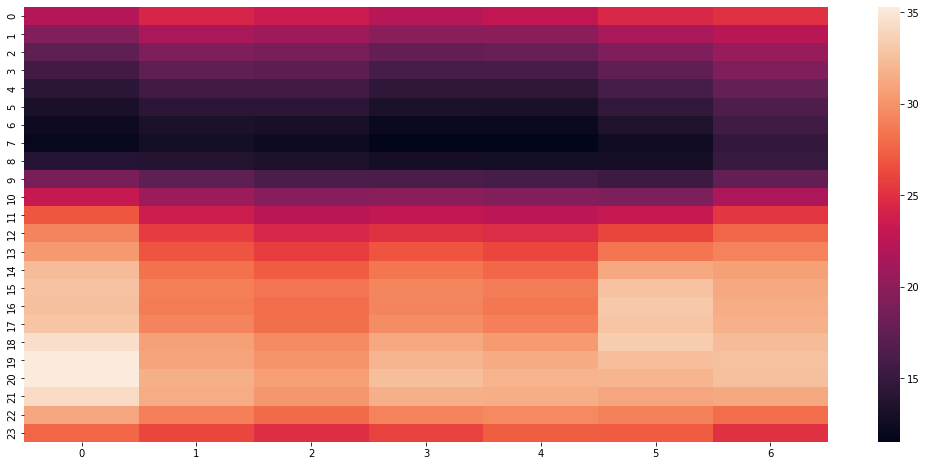

In [32]:
import seaborn as sns#; sns.set_theme()

ax = sns.heatmap(data)

Text(0.5, 1.0, 'Lundi')

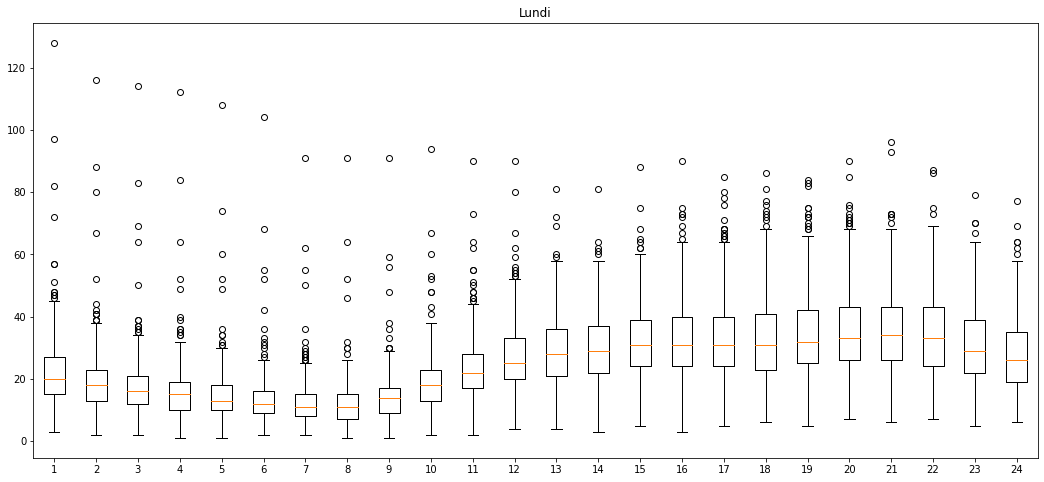

In [33]:
g=df0.groupby(['hour', 'dow'])
l=0
plt.boxplot([g.get_group((k,l))['patients'] for k in range(0,24)])
title("Lundi")

Text(0.5, 1.0, 'Lundi')

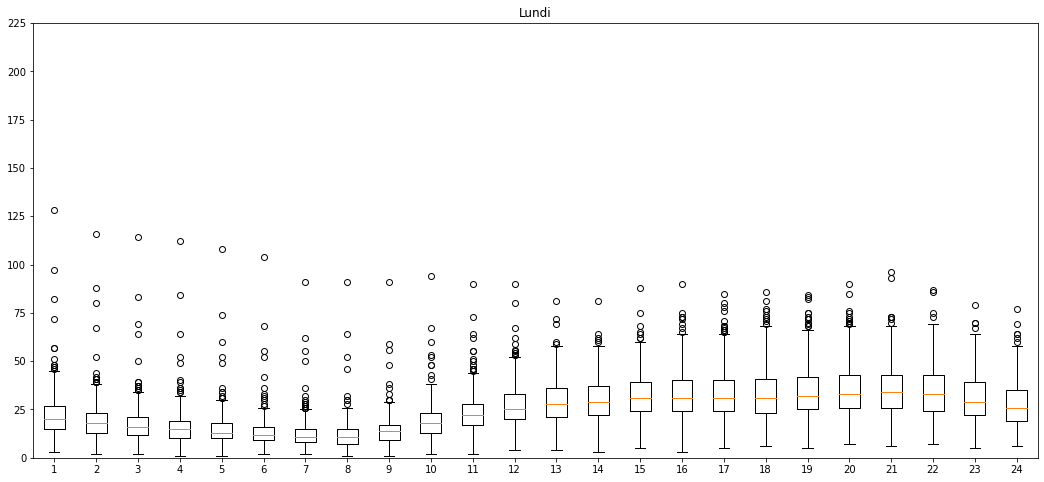

In [34]:
g=df0.groupby(['hour', 'dow'])
l=0
plt.boxplot([g.get_group((k,l))['patients'] for k in range(0,24)])
plt.ylim(0, 225)
title("Lundi")

## Predictions

### Baselines

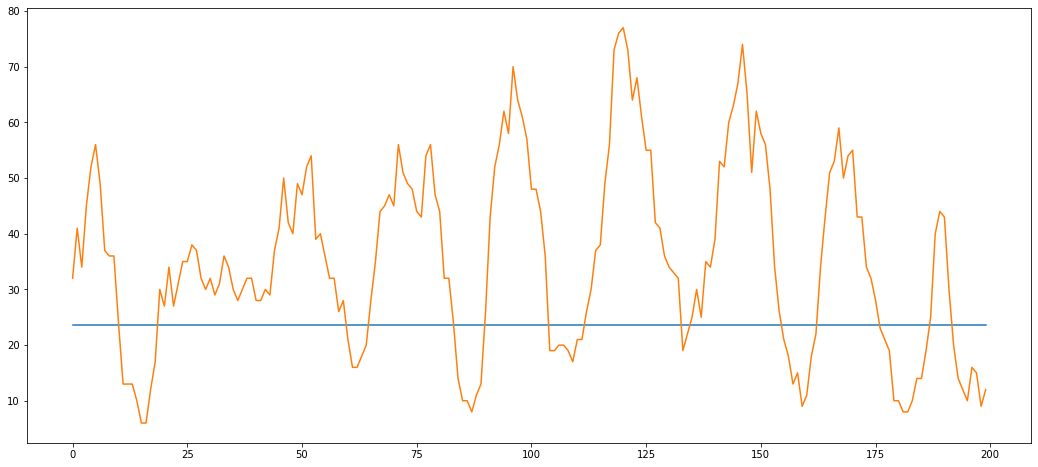

In [35]:
y_test = df['patients'].copy()
y_test_pred = [df['patients'].mean()]*len(y_test)
plot(range(200), y_test_pred[-200:], label="predicted")
plot(range(200), y_test[-200:], label="real")

In [36]:
mean_absolute_error(y_test_pred, y_test), sqrt(mean_squared_error(y_test_pred, y_test))

(9.568825226486103, 12.286060516844952)

In [37]:
for k in range(24):
    result = [df0.loc[df0.hour==k].patients.mean() for k in range(24)]*len(series)
    result = result[k:len(series)+k]
    print(k,mean_absolute_error(result, series.values), sqrt(mean_squared_error(result, series.values)))

0 7.600961424907738 10.190025752460299
1 7.769603490335899 10.377726629903298
2 8.240562331894663 10.88544637091488
3 8.907380440357791 11.605929872150929
4 9.67921634452993 12.437501854600319
5 10.480766366422717 13.298168364275726
6 11.25867808219178 14.13463677524113
7 11.989563858134733 14.911617292071824
8 12.644106680427845 15.598630378890771
9 13.196576005504472 16.17212395192054
10 13.621624813911302 16.611294010219037
11 13.890648339275662 16.888408971834053
12 13.986374923375243 16.982572882428975
13 13.900572577719396 16.888408971834053
14 13.642808306749233 16.611294010219037
15 13.230166654156502 16.17212395192054
16 12.68620773753675 15.598630378890771
17 12.034710126978172 14.911617292071824
18 11.3026108212923 14.13463677524113
19 10.514609707887656 13.298168364275728
20 9.700735053480955 12.437501854600319
21 8.923466929380123 11.60592987215093
22 8.25637558015888 10.88544637091488
23 7.783264195909175 10.377726629903298


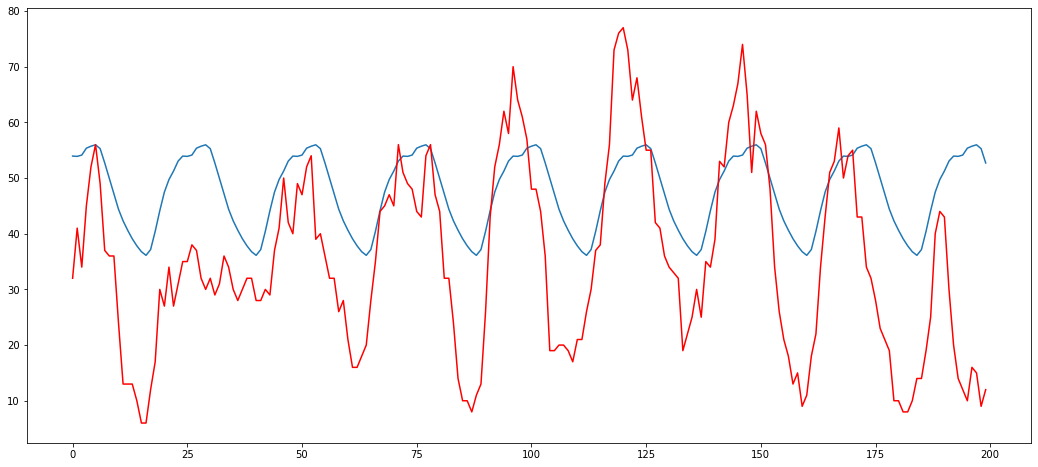

In [38]:
pyplot.plot(result[-200:]+series.mean())
pyplot.plot(series.values[-200:], color='red')

### More advanced approaches

#### Data preparation

In [39]:
target = 'patients'

In [40]:
lags = 24*7*4
for k in range(1, lags):
    df[f"{target}-{k}"] = df[target].shift(k)

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)
/tmp/ipykernel_87682/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

In [41]:
df = df[lags:]

In [42]:
cat = ['hour','week', 'dayofweek', 'month', 'year', 'dayofyear', 'daily_period', 'daily_period2',
       'apparent_moon','traffic_retour', 'accademic_holiday', 'moon_phase', 'public_holiday_eve',
       'traffic_depart',  'public_holiday', 'public_holiday_next_day']
num = ['influ_inc', 'ww_nancy','td_nancy', 'diar_inc100', 'moon_distance','vv_nancy', 't_nancy', 
       'chpox_inc100', 'cod_tend_nancy', 'u_nancy', 'diar_inc', 'chpox_inc','rr3_nancy', 'influ_inc100',
       'rafper_nancy', 'rr1_nancy', 'tend_nancy', 'pmer_nancy', 'pmer_strasbourg', 'dd_nancy',  
       'pres_nancy', 'n_nancy', 'ff_nancy']
num += ['encours']
num += [f"{target}-{k}" for k in range(1, lags)]
features = cat + num + [target]

In [43]:
df = df[features]

In [44]:
df.shape

(86928, 712)

In [45]:
train_val_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

split_date ='2020-01-01'
train_val_set = df.loc[df.index < split_date]
test_set = df.loc[df.index >= split_date]

In [46]:
enc = TargetEncoder(cols=cat)
encoder = enc.fit(train_val_set.drop(target, axis=1), train_val_set[target])

target_enc = encoder.transform(train_val_set.drop(target, axis=1))
target_enc[target] = train_val_set[target]
for col in cat:
    train_val_set[col] = target_enc[col]
    
target_enc = encoder.transform(test_set.drop(target, axis=1))
target_enc[target] = test_set[target]
for col in cat:
    test_set[col] = target_enc[col]

In [47]:
scaler = StandardScaler() 
scaler.fit(train_val_set.drop(target, axis=1))

target_enc = scaler.transform(train_val_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = train_val_set[target]
target_enc.index = train_val_set.index
for col in cat+num:
    train_val_set[col] = target_enc[col]

target_enc = scaler.transform(test_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = test_set[target]
target_enc.index = test_set.index
for col in cat+num:
    test_set[col] = target_enc[col]

In [48]:
X_train = train_val_set.drop('patients', axis=1)
y_train = train_val_set['patients'].copy()

X_test = test_set.drop('patients', axis=1)
y_test = test_set['patients'].copy()

In [49]:
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


reg1 = xgboost.XGBRegressor()
reg1.fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)

reg2 = LGBMRegressor()
reg2.fit(X_train, y_train)
y_pred2 = reg2.predict(X_test)

reg3 = Lasso()
reg3.fit(X_train, y_train)
y_pred3 = reg3.predict(X_test)

reg4 = RandomForestRegressor()
reg4.fit(X_train, y_train)
y_pred4 = reg4.predict(X_test)

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


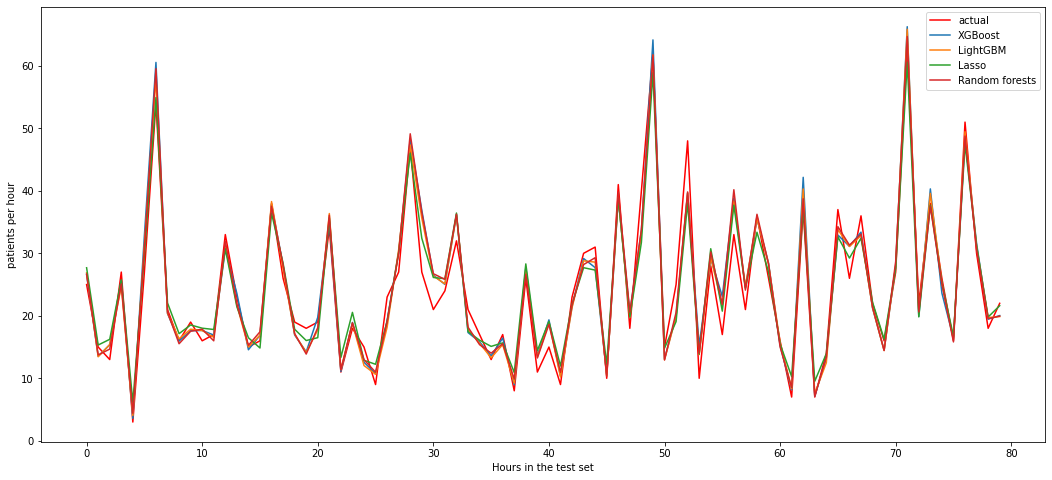

In [50]:
N=80
plt.plot(range(N),y_test[:N], color='red', label='actual')
plt.plot(range(N),y_pred1[:N], label="XGBoost")
plt.plot(range(N),y_pred2[:N], label="LightGBM")
plt.plot(range(N),y_pred3[:N], label="Lasso")
plt.plot(range(N),y_pred4[:N], label="Random forests")
xlabel("Hours in the test set")
ylabel("patients per hour")
legend()

#### Random forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(2.099318992292649, 2.788321665178014)

#### Lasso

In [52]:
from sklearn.linear_model import Lasso
reg = Lasso()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(2.3561933400671955, 3.026743554878294)

#### LightGBM

In [53]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(2.0444496840851585, 2.7101394103462875)

#### XGBoost

In [54]:
reg = xgboost.XGBRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(2.1084557084100344, 2.8206661131763515)

#### Feature selection & hyperparameter optimization with XGBoost

In [55]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
from sklearn.feature_selection import RFE

def get_features(df, target = 'appels', num_feats = 100):
    print("Coefficient de corrélation")
    ix = df.corr().sort_values(target, ascending=False).index
    df_sorted = df.loc[:, ix]
    Liste = list(df_sorted.columns)
    X = df.drop(target, axis=1)
    y = df[target]
    '''print("Random forests")
    embeded_rf_selector = SelectFromModel(
                    RandomForestRegressor(n_estimators=100),
                    max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()'''
    print("Régression linéaire")
    embeded_lr_selector = SelectFromModel(LinearRegression(),
                                      max_features=num_feats)
    embeded_lr_selector.fit(X, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    '''print("Chi-2 selector")
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()'''
    print("Extra trees")
    model = ExtraTreesRegressor()
    model.fit(X,y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    xt_features = list(feat_importances.nlargest(100).index)
    print("XGBoost")
    train_set, val_set = train_test_split(df, test_size=0.2)
    X_train = train_set.drop(target, axis=1)
    X_val = val_set.drop(target, axis=1)
    y_train = train_set[target]
    y_val = val_set[target]
    reg = xgboost.XGBRegressor(random_state = 42,
                               max_depth = 7,
                               n_estimators=100000)
    reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 10, verbose=False)
    a, b = X_train.columns, reg.feature_importances_
    res_xgb = sorted([(a[k], b[k]) for k in range(len(X.columns))], key=lambda x:x[1], reverse=True)
    features_xgb = [k[0] for k in res_xgb[:100]]
    print("LightGBM")
    lgbc=LGBMRegressor(n_estimators=500)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print("RFE Lasso")
    rfe_selector = RFE(estimator=Lasso(alpha=0.1),
                   n_features_to_select=num_feats,
                   step=100, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    total = Liste[:int(num_feats/2)]+Liste[-int(num_feats/2):]+embeded_lr_feature+xt_features+features_xgb+embeded_lgb_feature+rfe_feature
    return sorted(set([(k, total.count(k)) for k in total if total.count(k)>1]), key=lambda x:x[1], reverse=True)

In [56]:
variables = get_features(train_val_set, target=target, num_feats = 50)

Coefficient de corrélation
Régression linéaire
Extra trees
XGBoost


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


LightGBM
RFE Lasso
Fitting estimator with 711 features.
Fitting estimator with 611 features.
Fitting estimator with 511 features.
Fitting estimator with 411 features.
Fitting estimator with 311 features.
Fitting estimator with 211 features.
Fitting estimator with 111 features.


In [57]:
variables

[('hour', 6),
 ('patients-1', 6),
 ('encours', 6),
 ('patients-3', 5),
 ('t_nancy', 4),
 ('year', 4),
 ('patients-168', 4),
 ('patients-20', 4),
 ('daily_period2', 4),
 ('u_nancy', 4),
 ('patients-501', 3),
 ('patients-646', 3),
 ('patients-309', 3),
 ('pres_nancy', 3),
 ('patients-549', 3),
 ('patients-25', 3),
 ('patients-622', 3),
 ('patients-4', 3),
 ('patients-118', 3),
 ('patients-143', 3),
 ('patients-167', 3),
 ('patients-2', 3),
 ('patients-286', 3),
 ('patients-22', 3),
 ('patients-670', 3),
 ('patients-165', 3),
 ('patients-142', 3),
 ('patients-104', 3),
 ('patients-46', 3),
 ('patients-45', 3),
 ('patients-94', 3),
 ('patients-213', 2),
 ('patients-661', 2),
 ('diar_inc', 2),
 ('patients-141', 2),
 ('patients-429', 2),
 ('week', 2),
 ('patients-166', 2),
 ('patients-49', 2),
 ('patients-71', 2),
 ('patients-203', 2),
 ('patients-169', 2),
 ('moon_distance', 2),
 ('patients-8', 2),
 ('patients-333', 2),
 ('patients-164', 2),
 ('patients-563', 2),
 ('patients-587', 2),
 ('pa

In [58]:
train_val_set0 = train_val_set.copy()

In [59]:
from sklearn.model_selection import KFold

def teste(df, variables, max_depth = 1, ok = target):
    liste = [k for k in df.columns if k not in variables]
    if ok not in liste:
        liste.append(ok)
    if max_depth == 1:
        etendue = range(2,16)
    else:
        etendue = [max_depth]
    txt = str(variables)
    txt += '\n'
    min_rmse, best_depth = None, None
    for max_depth in etendue:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        RMSEs = []
        for train_index, test_index in kf.split(df):
            train_val_set, test_set = df.iloc[train_index], df.iloc[test_index]
            train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)
            X_train = train_set.drop(liste, axis=1)
            X_val = val_set.drop(liste, axis=1)
            X_test = test_set.drop(liste, axis=1)
            y_train = train_set[ok]
            y_val = val_set[ok]
            y_test = test_set[ok]
            reg = xgboost.XGBRegressor(random_state = 42,
                                       learning_rate=0.1,
                                       max_depth = max_depth,
                                       n_estimators=10000,
                                       #objective = 'count:poisson',
                                       #eval_metric = 'poisson-nloglik',
                                       verbosity=0)
            reg.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    early_stopping_rounds = 15,
                    verbose=False)
            y_pred = reg.predict(X_test)
            RMSEs.append(sqrt(mean_squared_error(y_test, y_pred)))
        rmse = mean(RMSEs)
        txt += str(max_depth)+' '+str(mean_absolute_error(y_test, y_pred))+' '+str(rmse)
        txt += '\n'
        if not min_rmse:
            min_rmse = rmse
            reg0 = deepcopy(reg)
            best_depth = max_depth
        elif rmse < min_rmse:
            min_rmse = rmse
            best_depth = max_depth
            reg0 = deepcopy(reg)            
    print(txt)
    return (reg0, min_rmse, best_depth)


In [ ]:
from copy import deepcopy
from pickle import dump

mes_vars = [variables[0][0]]
reg0, best_rmse, best_depth = teste(train_val_set0, mes_vars)

variables = [k[0] for k in variables if k[0] not in mes_vars]
variables = [k for k in variables if k not in ['trend', 'creneau']]
    
print(variables)
les_rmse = [best_rmse]
for k in range(20):
    for var in variables:
        var0 = var
        print(k, ', '.join(mes_vars+[var]))
        reg, min_rmse, max_depth = teste(train_val_set0, mes_vars+[var])
        print(min_rmse, best_rmse)
        if min_rmse < best_rmse:
            print(k, "amélioration", best_rmse, "->", min_rmse)
            reg0, best_rmse, best_depth = reg, min_rmse, max_depth
            with open(f'regs/{target}-{best_rmse:.5f}_{best_depth}_{k}.pkl', 'wb') as f:
                 dump(reg0, f)
            mes_vars.append(var)
            les_rmse.append(best_rmse)
            variables.remove(var)
            with open(f'regs/{target}-{best_rmse:.5f}_{best_depth}_{k}.txt', 'w') as f:
                 f.write(str(mes_vars))
            break
    if var0 == variables[-1]:
        break

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour']
2 7.674296628067745 10.227931526451343
3 7.672610139174814 10.228292365554463
4 7.672688949234979 10.228432397763921
5 7.673721626979509 10.228491280910877
6 7.6732668601681455 10.228448216078734
7 7.6732685483664245 10.228449072670703
8 7.673725793716172 10.228453644276634
9 7.673725793716172 10.228453644276634
10 7.6732685483664245 10.228449064067963
11 7.673725793716172 10.228453646775097
12 7.673725793716172 10.228453644276634
13 7.6732685483664245 10.228449085375034
14 7.673725793716172 10.228453656980964
15 7.673725793716172 10.228453644276634

['patients-1', 'encours', 'patients-3', 't_nancy', 'year', 'patients-168', 'patients-20', 'daily_period2', 'u_nancy', 'patients-501', 'patients-646', 'patients-309', 'pres_nancy', 'patients-549', 'patients-25', 'patients-622', 'patients-4', 'patients-118', 'patients-143', 'patients-167', 'patients-2', 'patients-286', 'patients-22', 'patients-670', 'patients-165', 'patients-142', 'patients-104', 'patients-46', 'patients-45', 'patie

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1']
2 3.19462751171388 4.220939826163996
3 3.1824880090121876 4.210344064864666
4 3.1842122266681363 4.212206981664872
5 3.1869550901632526 4.214423023013426
6 3.1914563901746003 4.219399885250534
7 3.1987983302409053 4.228303049657102
8 3.1992519436329645 4.232340464169373
9 3.20782141843883 4.24216849335522
10 3.2144371226562796 4.250008012341121
11 3.2210638281049007 4.25940663072565
12 3.2256875630507773 4.265445778179435
13 3.227991390749405 4.269981167654281
14 3.231383859065541 4.274371188164569
15 3.2324352293032357 4.2762196611543875

4.210344064864666 10.227931526451343
0 amélioration 10.227931526451343 -> 4.210344064864666
1 hour, patients-1, encours


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours']
2 2.007503757162755 2.6754827453567893
3 2.0044168081817046 2.6766105172322083
4 2.0048656867501515 2.6769022310887918
5 2.0061688202274985 2.6795801181023813
6 2.007383914498855 2.68181080092291
7 2.008693307501028 2.6873005415663007
8 2.0075342100020417 2.695906459313082
9 2.014073002362409 2.7112586134422636
10 2.0246855295489565 2.731441973145216
11 2.0332671607838373 2.7559872638537977
12 2.047179839371572 2.781890839422862
13 2.063856829248148 2.8115192708221706
14 2.0828477346909127 2.8416011900945892
15 2.0988881139147373 2.868719732057316

2.6754827453567893 4.210344064864666
1 amélioration 4.210344064864666 -> 2.6754827453567893
2 hour, patients-1, encours, patients-3


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'patients-3']
2 2.006295738624436 2.6762460656289826
3 2.007020245587171 2.6788007454513356
4 2.00918473488029 2.679147805253137
5 2.0075407435333794 2.677782808877466
6 2.008005001180159 2.680533083734361
7 2.009633334265175 2.68758699794468
8 2.0144668861576496 2.6974429617706237
9 2.0140676501498747 2.7130778460956595
10 2.0274289873676943 2.731581981342609
11 2.037226020406984 2.7545899254481006
12 2.0560606852203804 2.780544948451529
13 2.0730285589246527 2.8065117587074466
14 2.0904156841746957 2.8412966476827695
15 2.1123060395843103 2.8714642751969732

2.6762460656289826 2.6754827453567893
2 hour, patients-1, encours, t_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 't_nancy']
2 2.006760993110472 2.677850509185592
3 2.0095991421386983 2.6815611121553706
4 2.0081795654507384 2.683741525895658
5 2.0074582376081023 2.681801172889331
6 2.008772371828059 2.686429053091202
7 2.008247229202335 2.693593082647771
8 2.006395726950305 2.7039348914183483
9 2.0168455146340967 2.7232336579167415
10 2.0231506612954346 2.7404036861046603
11 2.039753953915819 2.7667572465794645
12 2.0437614926497827 2.7886551535974755
13 2.0636040369369604 2.81382882768986
14 2.077371186888832 2.840505199302005
15 2.0857671166601146 2.8628694382537763

2.677850509185592 2.6754827453567893
2 hour, patients-1, encours, year


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year']
2 1.9930582573213624 2.6632916936317756
3 1.9945530882590043 2.6637546886725945
4 1.996880034228526 2.66507137969685
5 1.9962855455928197 2.6659312828360093
6 1.9972314118978995 2.669330366031358
7 1.996721189427314 2.675535976265826
8 1.9984216785976041 2.686958451521286
9 2.0068555364911846 2.7021902465718233
10 2.018398667705241 2.7241526839038586
11 2.027831842189107 2.7522777499117144
12 2.041040071295636 2.7826631786075886
13 2.064645815635331 2.817531995062027
14 2.081836013391781 2.8539012601269027
15 2.101125276380995 2.8865919409578664

2.6632916936317756 2.6754827453567893
2 amélioration 2.6754827453567893 -> 2.6632916936317756
3 hour, patients-1, encours, year, patients-3


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3']
2 1.9913368744088344 2.661075344251701
3 1.9950945369635706 2.6653674086529695
4 1.9988227957001972 2.6667418085663006
5 1.9977099773422342 2.6655225165978402
6 1.9976314290059447 2.6697644907050533
7 1.9976502335685267 2.675638243123094
8 2.001268077983505 2.6885621099898347
9 2.0088148239463233 2.703311627221845
10 2.0152651684480323 2.7243113764835254
11 2.033564978447117 2.7500069008235237
12 2.0434400696572057 2.773892781964735
13 2.0592825056185213 2.805180735291234
14 2.079121151638504 2.83376660928081
15 2.0943407181405047 2.860727309257302

2.661075344251701 2.6632916936317756
3 amélioration 2.6632916936317756 -> 2.661075344251701
4 hour, patients-1, encours, year, patients-3, t_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 't_nancy']
2 1.9917488118629878 2.662889038233003
3 1.9956151695816484 2.669547755792029
4 1.997503474307602 2.6694628180665267
5 1.9965563835616353 2.6685653424378724
6 1.9997440147646754 2.671815316407578
7 1.9971429251513675 2.680705040404422
8 2.004005463534057 2.6939629275911576
9 2.0048480036617318 2.708133829668862
10 2.0181648565463237 2.729365876293829
11 2.036591216488957 2.7548752707547473
12 2.045019811988391 2.7780690092137146
13 2.061170372198051 2.799693952867864
14 2.0796859970046833 2.826982919642295
15 2.094048602984903 2.847253188318703

2.662889038233003 2.661075344251701
4 hour, patients-1, encours, year, patients-3, patients-168


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'patients-168']
2 1.9937877703714137 2.66326846039429
3 1.9990694543943002 2.6687184445367356
4 1.9992739331509692 2.6692377540050174
5 1.9996971565740425 2.6668703607307527
6 2.000997082003239 2.6717473693390854
7 2.003231410051784 2.678939060955876
8 2.003089525891955 2.690324206499908
9 2.011855569162141 2.7057063537582566
10 2.024645313350572 2.7263244802875066
11 2.038837854225196 2.752243845758348
12 2.0482448291805992 2.772846034182432
13 2.0597946343663303 2.7981690110562627
14 2.0815262871721814 2.8204998042730187
15 2.085590104253463 2.842297131876644

2.66326846039429 2.661075344251701
4 hour, patients-1, encours, year, patients-3, patients-20


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'patients-20']
2 1.9918554803832769 2.665996180615788
3 1.9946615662611111 2.669114488704788
4 1.9984900130943077 2.6694439448199327
5 1.9963587173912969 2.6675127865569657
6 2.0013991633571013 2.6726570780446073
7 1.999593950265915 2.6768509646540393
8 2.0044027283886297 2.6895444212553086
9 2.009853702176738 2.7059801350157344
10 2.021673785078481 2.728268876685563
11 2.033047353292218 2.747379133007732
12 2.046629027976433 2.774150422346022
13 2.0595300571480326 2.796454095968132
14 2.077654496996712 2.8236262860317214
15 2.089936444522459 2.84292895000793

2.665996180615788 2.661075344251701
4 hour, patients-1, encours, year, patients-3, daily_period2


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2']
2 1.9916644667821402 2.660780252817331
3 1.9958995983351706 2.6643792667605246
4 1.9942935856253654 2.664057176882918
5 1.992841195101912 2.6614962594740232
6 1.9934693459878887 2.6644777357317233
7 1.9944809715758804 2.6715136366606713
8 1.998713314164669 2.682824662430833
9 2.007662657248689 2.700394879873626
10 2.015059269066854 2.718714249778917
11 2.0285842926518685 2.743948468165686
12 2.0422389965342624 2.773413017810012
13 2.0597948348998747 2.8014939885773917
14 2.0759047076281782 2.829773667532995
15 2.09037608315813 2.861139138819708

2.660780252817331 2.661075344251701
4 amélioration 2.661075344251701 -> 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, t_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 't_nancy']
2 1.9931691321261764 2.663872204636903
3 1.9959026051640751 2.66748953547998
4 1.996214279724429 2.666747615204092
5 1.99496960777094 2.6631873470671823
6 1.9955726871553563 2.6677103632506025
7 1.9938057351462073 2.675341388157235
8 1.9977387567086915 2.6875429380717235
9 2.01017898268867 2.7049769863694517
10 2.013454493911986 2.7258248208135334
11 2.02779719832645 2.750666385668194
12 2.049411177849475 2.7759327520033077
13 2.063810359636257 2.8025148309420094
14 2.080047138890282 2.821950603356652
15 2.0969010956043275 2.8459593072940246

2.6631873470671823 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-168


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-168']
2 1.992923977150806 2.6633673357793093
3 1.9998581462167686 2.6668882745678113
4 1.9979575072292766 2.6659196740777684
5 1.9968635980548755 2.662959502084254
6 1.9994283639942396 2.668470994538059
7 1.9993264744739132 2.6742389261809807
8 1.999991798172883 2.6864616464780626
9 2.0126125543563913 2.7030792734688123
10 2.0193672676752583 2.72110643447781
11 2.030003429303438 2.7463454298375636
12 2.0534628136407584 2.768665347914714
13 2.0650226589691925 2.8005186628344787
14 2.0815592620919277 2.824742147617755
15 2.092733519316268 2.843616792355154

2.662959502084254 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-20


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-20']
2 1.9910571134001283 2.6639275759361967
3 1.996076413645359 2.6667701938777433
4 1.997345814682267 2.6668126710255953
5 1.9941028176212503 2.6634293587678206
6 1.9958537128213703 2.6678254670230466
7 1.9950753023972756 2.6742402665910125
8 2.00228324762219 2.688565438171622
9 2.0076031875586353 2.7037912021415766
10 2.0199975791610383 2.723005950013577
11 2.033965556977945 2.747043904699627
12 2.0446269590089403 2.772891369449903
13 2.0687113141221563 2.796136546800286
14 2.077037163608061 2.8203970161741547
15 2.089618989052977 2.8387058036054094

2.6634293587678206 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, u_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'u_nancy']
2 1.9922192410933137 2.661730197630921
3 1.9954914629699376 2.6662570107918966
4 1.999515656085065 2.6671239997919325
5 1.994107566176045 2.6626164564461576
6 1.9967136930589673 2.667695384224964
7 1.9943958178809706 2.67417835350887
8 2.0013677239640884 2.6871093573735427
9 2.0115502703659556 2.700844408970055
10 2.0175093026434787 2.723308154435486
11 2.030757700553529 2.7477976272045557
12 2.044358303470964 2.7730328523826007
13 2.0607672789366314 2.801547122012408
14 2.0755078453235254 2.8229541374718936
15 2.0935129798243777 2.8473052425983627

2.661730197630921 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-501


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-501']
2 1.9931298282971353 2.6624042186140673
3 1.99731068795256 2.6664358202611775
4 1.999829620757184 2.666724677271897
5 1.9961994110955086 2.662973279128743
6 1.9989762686606554 2.66605080973122
7 1.9977094373776374 2.6751649266082125
8 2.001525231320727 2.687089178821849
9 2.0074641337794477 2.7019689415930452
10 2.020335346451771 2.7225670906257937
11 2.0346342761659884 2.7480050494655104
12 2.050661702719371 2.7735724165725397
13 2.0627531241609476 2.7951295990337135
14 2.0830354259673776 2.8272338586681327
15 2.092627637784715 2.8453530342609774

2.6624042186140673 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-646


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-646']
2 1.9947254302208883 2.6620737369130003
3 1.9967477256997344 2.6667237672017943
4 1.9992940404958892 2.6674598857684857
5 1.9965106994385071 2.66389528747873
6 1.9964072221152427 2.667327709660028
7 1.9980380172046532 2.675103019418354
8 2.000403250278602 2.6864480943679725
9 2.0096847913990015 2.6998871076217847
10 2.0169802410852165 2.718112721803878
11 2.03682040325228 2.7433147416216808
12 2.0429769926092423 2.765166378730684
13 2.0624005158965124 2.789872983146383
14 2.0752440784935433 2.8178961665153817
15 2.09306116955425 2.8379765428790282

2.6620737369130003 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-309


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-309']
2 1.9922259283076083 2.6634536008131025
3 1.9970732644641747 2.6680896666991134
4 1.9988478223654194 2.667847565072136
5 1.994183292531542 2.6634962944486618
6 1.9937680343769733 2.6668092748002623
7 1.9930480966922501 2.675034366881765
8 2.003928945141343 2.688688258611473
9 2.0044090911973163 2.7033391991338744
10 2.0172532433394834 2.723998626612856
11 2.0322644258491738 2.7492974334503097
12 2.0451553205854767 2.769629734192524
13 2.0662629374286583 2.7972733772365923
14 2.074384550150695 2.8195048498177746
15 2.091601706327705 2.8416530471487556

2.6634536008131025 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, pres_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'pres_nancy']
2 1.9940292975375937 2.663067442543126
3 1.9972721144561285 2.6679117113456035
4 1.9966574855189505 2.6673137492694052
5 1.9956643472620903 2.663805368360308
6 1.9942584834566464 2.6683057536837076
7 1.9982103908031124 2.6771490272816743
8 2.0036371098635763 2.6889197859967253
9 2.015529069058471 2.7089780202113483
10 2.022626428210533 2.7299131591046
11 2.037053245758578 2.754493730607552
12 2.0455343378646162 2.780595035902961
13 2.0596834598583227 2.808692964137741
14 2.075340532128551 2.8300040565494635
15 2.09084327724222 2.8501155089251484

2.663067442543126 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-549


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-549']
2 1.993892619698631 2.663887048659988
3 2.0001942593714683 2.6683198802011825
4 1.9993348405437974 2.6679578493301497
5 1.9952641530629374 2.663720832290111
6 1.995925313950888 2.667125443195582
7 1.9974023356652308 2.6752013460783526
8 2.0040795536331997 2.687082424095273
9 2.014965450305996 2.7046226646397478
10 2.022735442191594 2.725830911979778
11 2.0419475637035602 2.7472349352142693
12 2.0514672970099803 2.7707738070004817
13 2.0666513715045425 2.795421614344201
14 2.07631179659933 2.819966795254511
15 2.0957503781292606 2.8479130390615843

2.663720832290111 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-25


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-25']
2 1.9934337683662724 2.664646842534588
3 1.9949988335808153 2.6678324216462466
4 2.000135327186055 2.6668911876767023
5 1.9941676104072186 2.662943805363682
6 1.9938945100589973 2.6672654375889495
7 1.996965382894223 2.6731062712621796
8 2.0004140836927853 2.682960695199932
9 2.008534242315199 2.7013238087593545
10 2.01376514508356 2.7192100947891604
11 2.026815639004681 2.7455910459769397
12 2.0451386371391203 2.7674219911482987
13 2.0601838162345105 2.7928719788684178
14 2.081838137456525 2.8206121431661026
15 2.091691689657383 2.8406253724283443

2.662943805363682 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-622


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-622']
2 1.9948337167407166 2.6631516686507135
3 1.999042640464005 2.6679627948771327
4 1.9994529496588034 2.66678443490568
5 1.997260849863968 2.663648995828788
6 1.9941005548218527 2.667614673971329
7 1.9976142545026851 2.6761081526308517
8 2.0061076143571692 2.6869213302617725
9 2.013548736663807 2.700577755303339
10 2.0193658943384722 2.722099361658569
11 2.0315811264041788 2.740880770088596
12 2.0513938101400133 2.7689633305794863
13 2.0603432070516394 2.7931947182569443
14 2.0839720970174516 2.821466821889877
15 2.083655230000268 2.8403225273563493

2.6631516686507135 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-4


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-4']
2 1.9941377079980553 2.664413007700076
3 1.9969869247019754 2.665929917589731
4 1.9971706782790961 2.666001768177849
5 1.9946695440779618 2.663321115652927
6 1.996940322106756 2.6669661720625495
7 1.996725701072074 2.6726162598184957
8 1.9990659781252478 2.6853636208694716
9 2.0015587960041765 2.6990905718071625
10 2.013862565652646 2.718887799937517
11 2.02820353271257 2.7449848165626967
12 2.0468047008128356 2.767891581964043
13 2.0614911743817674 2.7942639449738147
14 2.0767598546782136 2.8210120732668416
15 2.084610779685881 2.8442894078625747

2.663321115652927 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-118


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-118']
2 1.992474723571945 2.662565349161796
3 1.9964512513566366 2.6662057133709838
4 1.9991319006738013 2.6654891356563954
5 1.9963152049806292 2.6638723558275696
6 1.9977160140396295 2.6677149295547613
7 1.9963588360434537 2.6734472938153813
8 1.9983901388263923 2.684406472051494
9 2.003446936538791 2.7016526953976685
10 2.012198945400802 2.719081354040011
11 2.027867154559768 2.7444555983318883
12 2.04875210795829 2.7699099349209213
13 2.052447310648055 2.789741706324139
14 2.074145971845888 2.815804952152292
15 2.0923883391671185 2.8394210168893705

2.662565349161796 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-143


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-143']
2 1.9940719662691144 2.6646903154270776
3 1.9971547709830986 2.6680721486586436
4 1.9961176102690084 2.66753927085267
5 1.9937983418302971 2.6640255808162125
6 1.9959311695286759 2.667855311925447
7 1.997285796293487 2.67513041357945
8 2.001121295880133 2.6870958288139493
9 2.0118047629823486 2.7042016942342952
10 2.017630989520002 2.7242781724799343
11 2.029545266488725 2.747764875102658
12 2.0440305677559447 2.7733734288807304
13 2.0630160491203213 2.8023849552554365
14 2.0744641064988976 2.8258913801512415
15 2.084794591526242 2.8461124406947147

2.6640255808162125 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-167


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-167']
2 1.9933900956041963 2.6640971378871505
3 1.996966321423097 2.667620958689524
4 1.9994316811461472 2.6674013329236734
5 1.997132304690506 2.66360545010358
6 1.9994539206985225 2.668323834252805
7 2.0008284189010577 2.6752174055734943
8 2.0031837327301347 2.6859093157499974
9 2.00691039072977 2.7010898949973146
10 2.0210508878653783 2.7227353464000004
11 2.035473699679586 2.742924962365646
12 2.052513351685911 2.768618996100969
13 2.070095359430527 2.795501954673194
14 2.08633830214253 2.8208654944190967
15 2.1056829570421103 2.845608812765254

2.66360545010358 2.660780252817331
5 hour, patients-1, encours, year, patients-3, daily_period2, patients-2


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-2']
2 1.9923317313177131 2.6632406309403973
3 1.9958329883275239 2.6653148664916233
4 1.9946244255218282 2.6631053831220095
5 1.99400323923374 2.6601939037784246
6 1.9936521282510096 2.66593981725373
7 1.9970082572249115 2.670300723230013
8 2.0019695822847003 2.682754458988304
9 2.005698156735662 2.6963298566944682
10 2.0187586988050565 2.7184359402787424
11 2.028312433809942 2.7338355961699667
12 2.042687067435773 2.7565378857221106
13 2.053498847382762 2.785125033999717
14 2.069573928329634 2.8121912774624755
15 2.090868955182899 2.8370969272471322

2.6601939037784246 2.660780252817331
5 amélioration 2.660780252817331 -> 2.6601939037784246
6 hour, patients-1, encours, year, patients-3, daily_period2, patients-2, t_nancy


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-2', 't_nancy']
2 1.9933587895630762 2.664442828067344
3 1.9969121971485564 2.666615425273168
4 1.9980499081941456 2.6656005970775842
5 1.9955758637040726 2.66290847455637
6 1.9956417877954555 2.668104900648244
7 1.996078660793609 2.6749412857640857
8 1.998792645889759 2.6850240729379533
9 2.010658836935593 2.7032813141897227
10 2.020256008366795 2.7225777560056703
11 2.0346168608441926 2.7420598332884385
12 2.04438126438611 2.7658146832465604
13 2.056783340093491 2.789726857467566
14 2.061917409527943 2.813632415937208
15 2.0914202808545244 2.8343140073541435

2.66290847455637 2.6601939037784246
6 hour, patients-1, encours, year, patients-3, daily_period2, patients-2, patients-168


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

['hour', 'patients-1', 'encours', 'year', 'patients-3', 'daily_period2', 'patients-2', 'patients-168']
2 1.9937297805890908 2.6634378531090386
3 1.9997222936972825 2.6680350537091764
4 1.9995568018039136 2.6668067215457745
5 1.9970338100721208 2.6630600192952953
6 1.9989990149896515 2.668183999448204
7 1.9968270481592765 2.6725325160523923
8 2.005375697784531 2.6848112490951497
9 2.010766101845181 2.700059245496427
10 2.0188309257919155 2.7177874113524787
11 2.0337713068334544 2.7398760264887727
12 2.0524220311730836 2.7664352372081313
13 2.0587927277553755 2.785778183866841
14 2.0811877520495115 2.809732820406018
15 2.090843233443006 2.8243872282309668

2.6630600192952953 2.6601939037784246
6 hour, patients-1, encours, year, patients-3, daily_period2, patients-2, patients-20


/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the 

In [ ]:


train_val_set, test_set = df.loc[df.year<2019], df.loc[df.year==2019]

enc = TargetEncoder(cols=cat)
encoder = enc.fit(train_val_set.drop(target, axis=1), train_val_set[target])

target_enc = encoder.transform(train_val_set.drop(target, axis=1))
target_enc[target] = train_val_set[target]
for col in cat:
    train_val_set[col] = target_enc[col]
    
target_enc = encoder.transform(test_set.drop(target, axis=1))
target_enc[target] = test_set[target]
for col in cat:
    test_set[col] = target_enc[col]
    

scaler = StandardScaler() 
scaler.fit(train_val_set.drop(target, axis=1))

target_enc = scaler.transform(train_val_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = train_val_set[target]
target_enc.index = train_val_set.index
for col in cat+num:
    train_val_set[col] = target_enc[col]

target_enc = scaler.transform(test_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = test_set[target]
target_enc.index = test_set.index
for col in cat+num:
    test_set[col] = target_enc[col]

    
var = ['encours', 'patients-1', 'hour', 'year', 'patients-3', 'daily_period2', 'patients-2']
train_val_set = train_val_set[var+['patients']]
test_set = test_set[var+['patients']]

train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

'''X_train = train_val_set.drop('patients', axis=1)
y_train = train_val_set['patients'].copy()

X_test = test_set.drop('patients', axis=1)
y_test = test_set['patients'].copy()
'''


X_train = train_set.drop(target, axis=1)
X_val = val_set.drop(target, axis=1)
y_train = train_set[target]
y_val = val_set[target]


X_test = test_set.drop([target], axis=1)
y_test = test_set[target]


ok = []
depth = 5

reg = xgboost.XGBRegressor(random_state = 42,
                           max_depth = depth,
                           n_estimators = 10000,
                           objective = 'count:poisson')

reg.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 10)
y_pred = reg.predict(X_test[var])
ok.append((depth, mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))))
print(ok)

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[N:2*N], label='actual')
plt.plot(range(N), y_pred[N:2*N], label='predicted')
plt.legend()

In [ ]:
assert False

In [ ]:
depth = 5
var = ['encours', 'patients-1', 'hour', 'year', 'patients-3', 'daily_period2', 'patients-2']
train_val_set = train_val_set0[var+['patients']]

train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

X_train = train_set.drop(target, axis=1)
X_val = val_set.drop(target, axis=1)
y_train = train_set[target]
y_val = val_set[target]


X_test = test_set.drop([target], axis=1)
y_test = test_set[target]

ok = []
reg = xgboost.XGBRegressor(random_state = 42,
                           max_depth = depth,
                           n_estimators = 10000,
                           objective = 'count:poisson')

reg.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 10)
y_pred = reg.predict(X_test[var])
ok.append((depth, mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))))
print(ok)

In [ ]:


train_val_set, test_set = df.loc[df.year<2019], df.loc[df.year==2019]

enc = TargetEncoder(cols=cat)
encoder = enc.fit(train_val_set.drop(target, axis=1), train_val_set[target])

target_enc = encoder.transform(train_val_set.drop(target, axis=1))
target_enc[target] = train_val_set[target]
for col in cat:
    train_val_set[col] = target_enc[col]
    
target_enc = encoder.transform(test_set.drop(target, axis=1))
target_enc[target] = test_set[target]
for col in cat:
    test_set[col] = target_enc[col]
    

scaler = StandardScaler() 
scaler.fit(train_val_set.drop(target, axis=1))

target_enc = scaler.transform(train_val_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = train_val_set[target]
target_enc.index = train_val_set.index
for col in cat+num:
    train_val_set[col] = target_enc[col]

target_enc = scaler.transform(test_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = test_set[target]
target_enc.index = test_set.index
for col in cat+num:
    test_set[col] = target_enc[col]

    
var = ['encours', 'patients-1', 'hour', 'year', 'patients-3', 'daily_period2', 'patients-2']
train_val_set = train_val_set[var+['patients']]
test_set = test_set[var+['patients']]

train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

'''X_train = train_val_set.drop('patients', axis=1)
y_train = train_val_set['patients'].copy()

X_test = test_set.drop('patients', axis=1)
y_test = test_set['patients'].copy()
'''


X_train = train_set.drop(target, axis=1)
X_val = val_set.drop(target, axis=1)
y_train = train_set[target]
y_val = val_set[target]


X_test = test_set.drop([target], axis=1)
y_test = test_set[target]


ok = []
depth = 5

reg = xgboost.XGBRegressor(random_state = 42,
                           max_depth = depth,
                           n_estimators = 10000,
                           objective = 'count:poisson')

reg.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 10)
y_pred = reg.predict(X_test[var])
ok.append((depth, mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))))
print(ok)

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[N:2*N], label='actual')
plt.plot(range(N), y_pred[N:2*N], label='predicted')
plt.legend()

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[-N:], label='actual')
plt.plot(range(N), y_pred[-N:], label='predicted')
plt.legend()

| Method | MAE | RMSE |
| --- | --- | --- |
| Mean | 11.92 | 15.06 |
| Mean / hour | 9.34 | 12.22 |
| Lasso | 2.92 | 3.82 |
| XGBoost | 2.74 | 3.68 |
| Random forests | 2.71 | 3.62 |
| LightGBM | 2.66 | 3.56 |
| Now | 2.63 | 3.51 |